In [93]:
import os
import gc
import string
import textwrap
import warnings
import datetime
import random

import keras.utils as ku
import numpy as np
import tensorflow as tf
from google.colab import output
from IPython.display import Javascript
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, LSTM, Dense, Dropout, Embedding, Attention
from keras.layers import concatenate, Reshape, SpatialDropout1D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from numpy.random import seed
from tensorflow.keras import backend as K
from tensorflow import config as config
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#@title
input_len = max_sequence_len - 1
_model = Sequential(name="Text_generation")

# Add Input Embedding Layer
_model.add(Embedding(total_words, 10, input_length=input_len, name="Input"))
# Add Hidden Layer 1 - LSTM Layer
_model.add(LSTM(256, name="Hidden_1", dropout=0.5, return_sequences=True))
#model.add(Dropout(0.1, name="Dropout_1"))
# Add Hidden Layer 2 - LSTM Layer
_model.add(LSTM(128, name="Hidden_2", dropout=0.5, return_sequences=True))
#model.add(Dropout(0.1, name="Dropout_2"))
# Add Hidden Layer 3 - LSTM Layer
_model.add(LSTM(64, name="Hidden_3", dropout=0.5, return_sequences=True))
#model.add(Dropout(0.1, name="Dropout_3"))
# Add Hidden Layer 4 - LSTM Layer
_model.add(LSTM(32, name="Hidden_4", dropout=0.5, return_sequences=False))
#model.add(Dropout(0.1, name="Dropout_4"))
# Add Output Layer
_model.add(Dense(total_words, activation='softmax', name="Output"))

adam = tf.keras.optimizers.Adam(learning_rate=0.001)
adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.001)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001)

optimizer = adagrad

_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

_model.summary()

#Text preprocessing

In [116]:
path = tf.keras.utils.get_file(
    "sherlock",
    "https://www.gutenberg.org/files/1661/1661-0.txt"
)

path = "main.txt"

with open(path) as f:
    text = f.read().splitlines()

arr = []
for g in range(32):
    l = text
    random.shuffle(l)
    arr += l

text += arr
print(len(text))

def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in text]

5148


In [117]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
total_words

756

In [118]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)
print(len(predictors))

67716


#Model creation

In [119]:
#@title
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import backend as K
from tensorflow.keras import initializers

class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average attention mechanism from:
        Zhou, Peng, Wei Shi, Jun Tian, Zhenyu Qi, Bingchen Li, Hongwei Hao and Bo Xu.
        “Attention-Based Bidirectional Long Short-Term Memory Networks for Relation Classification.”
        ACL (2016). http://www.aclweb.org/anthology/P16-2034
    How to use:
    see: [BLOGPOST]
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)


    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'supports_masking': self.supports_masking,
            'return_attention': self.return_attention
        })
        return config

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.w = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_w'.format(self.name),
                                 initializer=self.init)
        self._trainable_weights = [self.w]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, h, mask=None):
        h_shape = K.shape(h)
        d_w, T = h_shape[0], h_shape[1]
        
        logits = K.dot(h, self.w)  # w^T h
        logits = K.reshape(logits, (d_w, T))
        alpha = K.exp(logits - K.max(logits, axis=-1, keepdims=True))  # exp
        
        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            alpha = alpha * mask
        alpha = alpha / K.sum(alpha, axis=1, keepdims=True) # softmax
        r = K.sum(h * K.expand_dims(alpha), axis=1)  # r = h*alpha^T
        h_star = K.tanh(r)  # h^* = tanh(r)
        if self.return_attention:
            return [h_star, alpha]
        return h_star

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [120]:
max_length     = max_sequence_len - 1
dim_embeddings = 100
rnn_size       = 256
rnn_amount     = 5
dropout        = 0.2
num_classes    = total_words

inp        = Input(shape=(max_length,), name="Input")
embed     = Embedding(num_classes, dim_embeddings, input_length=max_length, name="Embed")(inp)
embed     = SpatialDropout1D(dropout, name="Dropout")(embed)

rnn_list = []
for i in range(rnn_amount):
    prev_layer = embed if i == 0 else rnn_list[-1]
    rnn_list.append(LSTM(rnn_size, return_sequences=True, name=f"Rnn_{i}")(prev_layer))

rnn_concat = concatenate([embed] + rnn_list, name="Concat")
attention  = AttentionWeightedAverage(name="AttentionWeighted")(rnn_concat)
output     = Dense(num_classes, name='Output', activation='softmax')(attention)

model      = Model(inputs=[inp], outputs=[output])

optimizer = Adam(lr = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 44)]         0                                            
__________________________________________________________________________________________________
Embed (Embedding)               (None, 44, 100)      75600       Input[0][0]                      
__________________________________________________________________________________________________
Dropout (SpatialDropout1D)      (None, 44, 100)      0           Embed[0][0]                      
__________________________________________________________________________________________________
Rnn_0 (LSTM)                    (None, 44, 256)      365568      Dropout[0][0]                    
____________________________________________________________________________________________

#Model training

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 80})'''))

checkpoint = ModelCheckpoint("weights/weights.h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
lamb = LambdaCallback(on_epoch_end=lambda a,b: gc.collect())


epochs = 15
batch_size = 256
h = model.fit(predictors, label, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[checkpoint, lamb])

<IPython.core.display.Javascript object>

Epoch 1/15
265/265 [==============================] - 26s 77ms/step - loss: 5.7758

Epoch 00001: loss improved from inf to 5.39794, saving model to weights/weights.h5
Epoch 2/15
265/265 [==============================] - 21s 79ms/step - loss: 4.0489

Epoch 00002: loss improved from 5.39794 to 3.53676, saving model to weights/weights.h5
Epoch 3/15
265/265 [==============================] - 21s 79ms/step - loss: 2.0437

Epoch 00003: loss improved from 3.53676 to 1.66661, saving model to weights/weights.h5
Epoch 4/15
265/265 [==============================] - 20s 77ms/step - loss: 0.8109

Epoch 00004: loss improved from 1.66661 to 0.67687, saving model to weights/weights.h5
Epoch 5/15
265/265 [==============================] - 21s 78ms/step - loss: 0.3905

Epoch 00005: loss improved from 0.67687 to 0.34063, saving model to weights/weights.h5
Epoch 6/15
265/265 [==============================] - 21s 78ms/step - loss: 0.2313

Epoch 00006: loss improved from 0.34063 to 0.21149, saving model 

In [ ]:
model.load_weights("weights/weights.h5")

In [ ]:
model.load_weights("model.h5")

In [ ]:
model.save("model.h5")

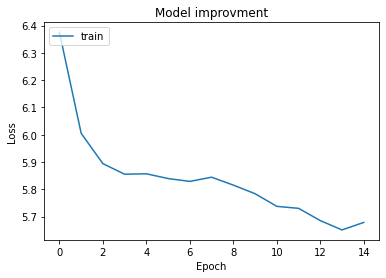

In [89]:
%matplotlib inline
plt.plot(h.history['loss'])
plt.title('Model improvment')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#Text generation

In [90]:
%matplotlib inline
generated, probs = generate_text("Fladdman:", 100, model, max_sequence_len, 0.2)


#plt.plot(probs)
#plt.legend(['probability'], loc='upper right')
#plt.title('Prediction')
#plt.ylabel('Chance')
#plt.xlabel('Letters')
#plt.show()

w = textwrap.TextWrapper(width=170, break_long_words=False)
new_text = "\n".join(w.wrap(generated)).lstrip()
print(new_text)

Fladdman: you the the the the the the the the the the the the the the that the the the the the the the the and the heroes the heroes heroes that heroes the that heroes
heroes the heroes that that heroes heroes that heroes heroes heroes heroes heroes heroes heroes heroes heroes heroes heroes heroes that heroes heroes heroes heroes that
heroes that heroes the the heroes that that that that the that that the heroes heroes the heroes that heroes and that heroes heroes that the the heroes that the that
heroes heroes heroes that heroes that heroes the


In [64]:
def generate_text(seed_text, next_words, _model, max_sequence_len, temp=0.2):
    res = dict((v,k) for k,v in tokenizer.word_index.items())
    a = []
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        _pred = _model.predict(token_list)
        #pred = np.argmax(_pred, axis=1)[0]
        pred = sample(_pred[0], temp)
        a.append(max(_pred[0]))

        seed_text += " " + res[pred]
    return seed_text, a

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")

    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)